In [ ]:
# Connect to Google Drive - remember to make a shortcut of the "Patches" folder to "My Drive"
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import OrderedDict
from datetime import datetime
from PIL import Image
import seaborn as sns
import shutil
import re
from torchvision.utils import save_image
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# import os
# import shutil
# import re

# def filter(input_folder, output_base_folder):
#     # Make sure input folder exists
#     if not os.path.isdir(input_folder):
#         print(f"Error: {input_folder} is not a valid directory.")
#         return

#     # Create the output base folder if it doesn't exist
#     os.makedirs(output_base_folder, exist_ok=True)

#     # Iterate over each item in the input folder
#     for item in os.listdir(input_folder):
#         item_path = os.path.join(input_folder, item)

#         # Skip unwanted files/folders
#         if "patched_" in item_path or item_path[-3:] == 'tif' or os.path.isdir(item_path):
#             continue

#         # Get file size
#         size = os.stat(item_path).st_size

#         # Apply all filters
#         if (
#             size > 2000 and
#             re.search(r"patch\d{1,3}", item, re.IGNORECASE) and
#             re.search(r"h&e", item, re.IGNORECASE)
#         ):
#             shutil.copy(item_path, output_base_folder)
#             # print(f"Copied '{item}' to '{output_base_folder}'")

# # Call the function
# if __name__ == "__main__":
#     input_folder = '/content/drive/My Drive/CMIL_SP2025_Patches_Apr16'  # Or your shared folder shortcut
#     output_base_folder = '/content/drive/My Drive/filtered_patches_SP2025_h&e'

#     filter(input_folder, output_base_folder)


In [ ]:
# import shutil

# # Define your specific cases
# benign_cases = [2, 21, 22, 25, 34, 45, 53, 77, 78, 79, 85, 90]
# high_grade_cases = [1, 3, 9, 12, 38, 49, 55, 60, 62, 70, 89, 92, 98, 99]

# selected_cases = set(benign_cases + high_grade_cases)

# # Define paths
# input_folder = '/content/drive/My Drive/filtered_patches_SP2025_h&e'
# output_folder = '/content/drive/My Drive/filtered_patches_h&e_subset'

# # Create output folder if it does not exist
# os.makedirs(output_folder, exist_ok=True)

# # Iterate through input_folder and copy selected images
# for filename in os.listdir(input_folder):
#     match = re.search(r"case_(\d+)", filename)
#     if match:
#         case_num = int(match.group(1))
#         if case_num in selected_cases:
#             src_path = os.path.join(input_folder, filename)
#             dst_path = os.path.join(output_folder, filename)
#             shutil.copy(src_path, dst_path)

# print(f"✅ Subset copying complete. Files are in: {output_folder}")


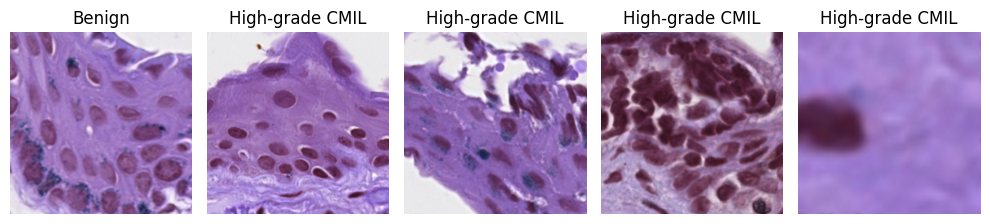

✅ Saved image paths and labels:
{'path': '/content/drive/My Drive/attention_patches_h&e/patch_0_label_0.png', 'label': 0}
{'path': '/content/drive/My Drive/attention_patches_h&e/patch_1_label_1.png', 'label': 1}
{'path': '/content/drive/My Drive/attention_patches_h&e/patch_2_label_1.png', 'label': 1}
{'path': '/content/drive/My Drive/attention_patches_h&e/patch_3_label_1.png', 'label': 1}
{'path': '/content/drive/My Drive/attention_patches_h&e/patch_4_label_1.png', 'label': 1}


In [ ]:
# Add labels to each patch and match by their case, randomly split patients into training, validation, and testing sets

labels = pd.read_csv('/content/drive/My Drive/case_grade_match.csv') # Replace with the path to file

# Define a function to group patches by case number
def group_patches(patch_dir):
    case_patches = {}
    for filename in os.listdir(patch_dir):
        match = re.search(r"case_(\d+)", filename)  # Using regex for case number extraction
        if match:
            case_num = int(match.group(1))
            if case_num not in case_patches:
                case_patches[case_num] = []
            case_patches[case_num].append(os.path.join(patch_dir, filename))
    return case_patches

# Define a custom dataset class for loading PNG images
class PNGDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None):
        self.case_patches = case_patches
        self.labels_df = labels_df
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Label benign images 0, and high-grade CMIL images 1
        for case_num, patches in case_patches.items():
            label = labels_df.loc[labels_df['Case'] == case_num, 'Class'].values[0]
            label = 0 if label == 1 else 1
            for patch_path in patches:
                self.image_paths.append(patch_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        # Get patch images
        image = Image.open(image_path).convert('RGB')
        # Get the label information using the labels dataframe based on case number
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

# Resize all patch images to 256x256
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Possible data augmentation for training data
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

image_folder_path = '/content/drive/My Drive/filtered_patches_SP2025_h&e_Apr27' # Replace with the path to filtered patches
patches = group_patches(image_folder_path)

# Get case numbers and their labels
case_nums = list(patches.keys())
dataset = labels.loc[[(int(x)-1) for x in case_nums]]

# Remove those that are equal to 2 (not classifying low-grade CMIL images currently)
noindex = ~dataset.Class.isin([0.0, 2.0])
X = dataset[noindex].Case
y = dataset[noindex].Class

# Ensure X and y have the same length before splitting
X = X.reset_index(drop=True)  # Reset index to avoid potential issues
y = y.reset_index(drop=True)  # Reset index to avoid potential issues

# Split the data into train, test, and validation sets
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)
train_X, val_X, y_train, y_val = train_test_split(train_X, y_train, test_size=0.2, stratify=y_train, random_state=40)

# Create the training, validation, and testing patches
train_patches = {case_num: patches[int(case_num)] for case_num in train_X} # Use train_X
val_patches = {case_num: patches[int(case_num)] for case_num in val_X} # Use val_X
test_patches = {case_num: patches[int(case_num)] for case_num in test_X} # Use test_X

# Create PNGDataset instances for train, validation, and test
train_dataset = PNGDataset(train_patches, labels, transform=train_transform)
val_dataset = PNGDataset(val_patches, labels, transform=transform)
test_dataset = PNGDataset(test_patches, labels, transform=transform)

# Create DataLoaders using the PNGDataset instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count())  # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # Shuffle validation data ### I DONT THINK THIS IS NEEDED
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # Do not shuffle test data

# Step 1: Get one batch from the train_loader
images, labels = next(iter(train_loader))

# Step 2: Select the first 5 images and labels
selected_images = images[:5]
selected_labels = labels[:5]

# Step 3: Save folder for images
save_dir = '/content/drive/My Drive/attention_patches_h&e'
os.makedirs(save_dir, exist_ok=True)

# Step 4: Denormalization function (to convert back to displayable format)
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Step 5: Save images and visualize them
fig, axes = plt.subplots(figsize=(10, 4), ncols=5)

for i in range(5):
    # Denormalize the tensor for visualization/saving
    denorm_img = denormalize(selected_images[i].clone())

    # Save image tensor as PNG
    img_path = os.path.join(save_dir, f'patch_{i}_label_{selected_labels[i].item()}.png')
    save_image(denorm_img, img_path)

    # Display the image
    img_np = denorm_img.permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)
    axes[i].imshow(img_np)
    axes[i].set_title('Benign' if selected_labels[i] == 0 else 'High-grade CMIL')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Step 6: Optional - save metadata (image path and label) for future reference
saved_patch_info = [
    {"path": os.path.join(save_dir, f'patch_{i}_label_{selected_labels[i].item()}.png'),
     "label": selected_labels[i].item()}
    for i in range(5)
]

print("✅ Saved image paths and labels:")
for info in saved_patch_info:
    print(info)


In [ ]:
# def validation(model, criterion, val_loader):
#     val_loss = 0
#     accuracy = 0

#     for images, labels in iter(val_loader):
#         output = model.forward(images)
#         val_loss += criterion(output, labels).item()

#         probabilities = torch.exp(output) # SHOULD NOT USE, the last linear layer outputs raw logits not log probabilities (LogSoftMax)

#         equality = labels.data == probabilities.max(dim=1)[1]
#         accuracy += equality.type(torch.FloatTensor).mean()

#     return val_loss, accuracy
def validation(model, criterion, val_loader):
    val_loss = 0
    correct_total = 0
    sample_total = 0

    model.eval()
    with torch.no_grad():
        for images, labels in iter(val_loader):
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item() * images.size(0)  # Scale by batch size

            _, preds = torch.max(output, dim=1)
            correct = (preds == labels).sum().item()
            correct_total += correct
            sample_total += labels.size(0)

    accuracy = correct_total / sample_total
    val_loss /= sample_total  # Now compute the proper average
    return val_loss, accuracy
  # Define training loop

# ---------- Checkpoint Save Function ----------
def save_checkpoint(model, arch, checkpoint_dir, epoch):
    os.makedirs(checkpoint_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{checkpoint_dir}/{timestamp}_{arch}_epoch{epoch}.pth"

    checkpoint = {
        "arch": arch,
        "model_state_dict": model.state_dict(),
        "epoch": epoch,
        "optimizer_state_dict": optimizer.state_dict(),
    }

    torch.save(checkpoint, filename)
    print(f"✅ Checkpoint saved: {filename}")

# ---------- Training Function ----------
def train_model(model, optimizer, criterion, train_loader, val_loader, arch, checkpoint_dir, epochs=5, start_epoch=0):
    plot_training = []
    plot_validation = []

    for e in range(start_epoch, start_epoch + epochs):
        model.train()
        running_loss = 0

        for images, labels in iter(train_loader):
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)

        # Validation
        validation_loss, accuracy = validation(model, criterion, val_loader)

        print(
            f"Epoch: {e + 1}/{epochs}.. "
            f"Training Loss: {epoch_loss:.3f}.. "
            f"Validation Loss: {validation_loss:.3f}.. "
            f"Validation Accuracy: {accuracy:.3f}"
        )

        plot_training.append(epoch_loss)
        plot_validation.append(validation_loss)

        # Save checkpoint
        save_checkpoint(model, arch, checkpoint_dir, epoch=e + 1)

    # Plot training & validation loss
    plt.plot(range(1, epochs + 1), plot_training, label='Training Loss')
    plt.plot(range(1, epochs + 1), plot_validation, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    return model


In [ ]:
#!pip install --upgrade timm

In [ ]:
import timm
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained CoAtNet-0
model = timm.create_model("coatnet_0_rw_224", pretrained=True, num_classes=2)

# Replace the classifier for binary classification
#model.head = nn.Linear(model.head.in_features, 2)
#model.to(device)

for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

In [ ]:
# checkpoint_path = "/content/drive/My Drive/checkpoints/20250415_073806_resnet50_epoch1.pth"
# checkpoint = torch.load(checkpoint_path)

# model = models.resnet50(weights=None)  # We will load weights manually
# num_classes = 2
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)

# model.load_state_dict(checkpoint['model_state_dict'])
# start_epoch = checkpoint["epoch"]


Epoch: 1/5.. Training Loss: 0.580.. Validation Loss: 0.548.. Validation Accuracy: 0.735
✅ Checkpoint saved: /content/drive/MyDrive/checkpoints/20250512_230149_coatnet_0_epoch1.pth
Epoch: 2/5.. Training Loss: 0.495.. Validation Loss: 0.553.. Validation Accuracy: 0.724
✅ Checkpoint saved: /content/drive/MyDrive/checkpoints/20250513_004329_coatnet_0_epoch2.pth
Epoch: 3/5.. Training Loss: 0.461.. Validation Loss: 0.570.. Validation Accuracy: 0.714
✅ Checkpoint saved: /content/drive/MyDrive/checkpoints/20250513_022451_coatnet_0_epoch3.pth
Epoch: 4/5.. Training Loss: 0.437.. Validation Loss: 0.604.. Validation Accuracy: 0.683
✅ Checkpoint saved: /content/drive/MyDrive/checkpoints/20250513_040701_coatnet_0_epoch4.pth
Epoch: 5/5.. Training Loss: 0.422.. Validation Loss: 0.582.. Validation Accuracy: 0.708
✅ Checkpoint saved: /content/drive/MyDrive/checkpoints/20250513_054842_coatnet_0_epoch5.pth


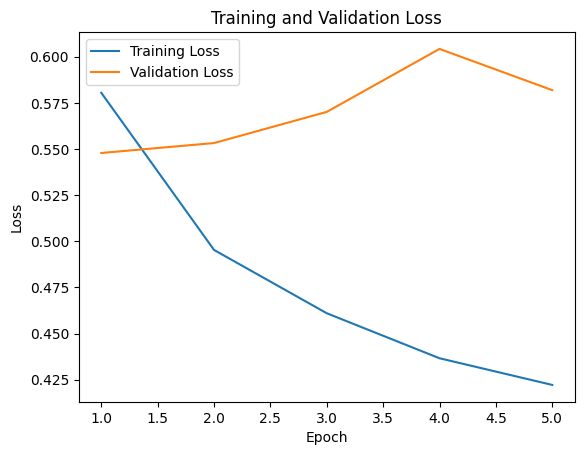

In [ ]:
# Create model instance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_dir = "/content/drive/MyDrive/checkpoints"
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Loss function
criterion = nn.CrossEntropyLoss()

# Train
trained_model = train_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    arch='coatnet_0',
    checkpoint_dir=checkpoint_dir,
    epochs=5,
    start_epoch=0
)
torch.save(model.state_dict(), "/content/drive/MyDrive/checkpoints/CoAtNeth&e_final.pth")

In [ ]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)  # raw logits
        preds = torch.argmax(output, dim=1)

        predictions += preds.cpu().tolist()
        true_labels += labels.cpu().tolist()

print(classification_report(true_labels, predictions, target_names=['Benign', 'High-grade CMIL']))


                 precision    recall  f1-score   support

         Benign       0.36      0.24      0.29      1602
High-grade CMIL       0.62      0.75      0.68      2700

       accuracy                           0.56      4302
      macro avg       0.49      0.49      0.48      4302
   weighted avg       0.53      0.56      0.54      4302



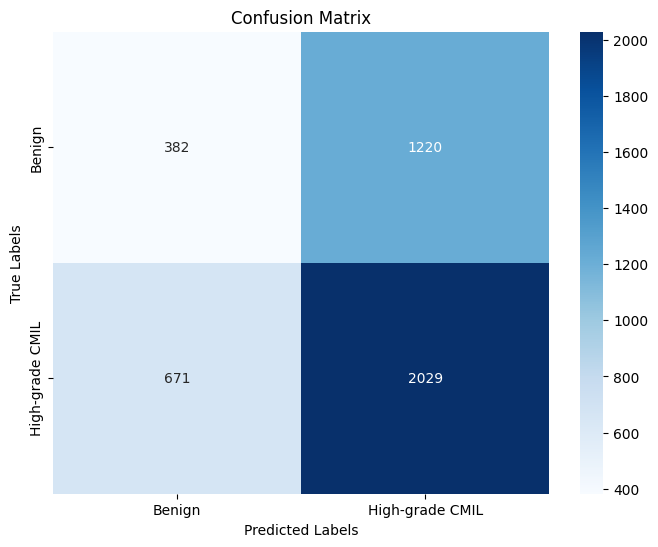

In [ ]:
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Benign', 'High-grade CMIL'],
            yticklabels=['Benign', 'High-grade CMIL'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
case_predictions = {}
case_true_labels = {}
case_accuracies = {}

# Step 1: Create a mapping from image path → case number
image_to_case = {patch_path: case_num for case_num, patches in test_patches.items() for patch_path in patches}

# Step 2: Iterate over test dataset using the original image paths from test_dataset.image_paths
for i in range(len(test_dataset)):
    image_path = test_dataset.image_paths[i]     # Get original image path
    label = test_dataset.labels[i]               # Get true label
    case_num = image_to_case[image_path]         # Get case number
    prediction = predictions[i]                  # Get predicted label from earlier inference

    # Aggregate predictions by case
    if case_num not in case_predictions:
        case_predictions[case_num] = []
        case_true_labels[case_num] = []
    case_predictions[case_num].append(prediction)
    case_true_labels[case_num].append(label)

# Step 3: Compute case-level accuracy
for case_num, preds in case_predictions.items():
    correct = sum(p == t for p, t in zip(preds, case_true_labels[case_num]))
    accuracy = correct / len(preds)
    case_accuracies[case_num] = accuracy

# Step 4: Print results
for case_num, accuracy in case_accuracies.items():
    true_label = case_true_labels[case_num][0]  # All patches from the same case have the same label
    label_str = 'Benign' if true_label == 0 else 'High-grade CMIL'
    print(f"Case {case_num}: Accuracy = {accuracy:.4f}, True Label = {label_str}")


Case 44: Accuracy = 0.8129, True Label = High-grade CMIL
Case 28: Accuracy = 0.2555, True Label = Benign
Case 92: Accuracy = 0.8246, True Label = High-grade CMIL
Case 36: Accuracy = 0.2632, True Label = Benign
Case 100: Accuracy = 0.8267, True Label = High-grade CMIL
Case 73: Accuracy = 0.5000, True Label = High-grade CMIL
Case 88: Accuracy = 0.9800, True Label = High-grade CMIL
Case 34: Accuracy = 0.0965, True Label = Benign
Case 7: Accuracy = 0.9348, True Label = High-grade CMIL
Case 40: Accuracy = 0.8689, True Label = High-grade CMIL
Case 48: Accuracy = 0.7204, True Label = High-grade CMIL
Case 32: Accuracy = 0.9135, True Label = High-grade CMIL
Case 30: Accuracy = 0.3152, True Label = Benign


In [ ]:
import matplotlib.pyplot as plt

def show_gradcam_with_legend(original_img, cam, title=None):
    """
    Displays Grad-CAM overlay alongside the heatmap with a colorbar.

    Parameters:
    - original_img: Original image as a NumPy array (H, W, 3), uint8
    - cam: Grad-CAM heatmap as a NumPy array (H, W), float32 in [0, 1]
    """
    cam_resized = cv2.resize(cam, (original_img.shape[1], original_img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap, 0.4, original_img, 0.6, 0)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Overlay image
    axs[0].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    axs[0].axis('off')
    axs[0].set_title("Grad-CAM Overlay")

    # Raw heatmap with colorbar
    im = axs[1].imshow(cam_resized, cmap='jet')
    axs[1].axis('off')
    axs[1].set_title("Attention Map (Color Scale)")
    cbar = fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
    cbar.set_label('Attention Strength')

    if title:
        plt.suptitle(title)

    plt.tight_layout()
    plt.show()

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        def save_gradient(grad):
            self.gradients = grad

        # Hook for activations
        def forward_hook(module, input, output):
            self.activations = output
            output.register_hook(save_gradient)

        self.target_layer.register_forward_hook(forward_hook)

    def __call__(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax().item()

        self.model.zero_grad()
        output[0, class_idx].backward()

        grads = self.gradients  # [C, H, W]
        activations = self.activations[0]  # [C, H, W]
        weights = grads.mean(dim=(1, 2))  # Global Average Pooling: [C]

        cam = torch.zeros(activations.shape[1:], dtype=torch.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = F.relu(cam)
        cam -= cam.min()
        cam /= cam.max()
        return cam.detach().cpu().numpy()

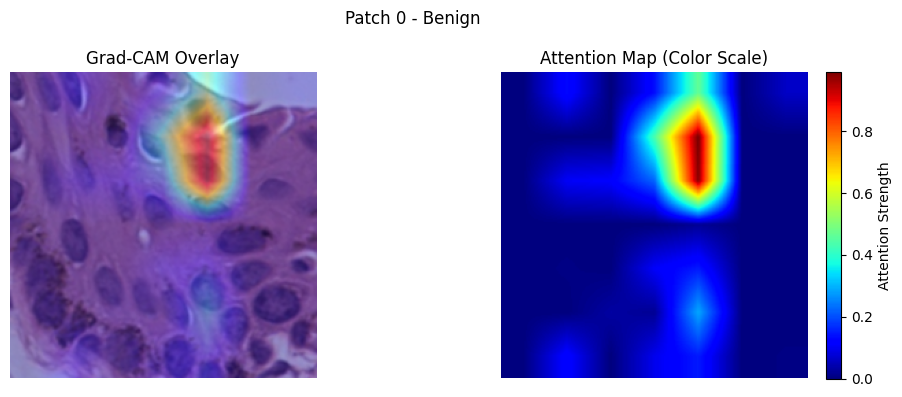

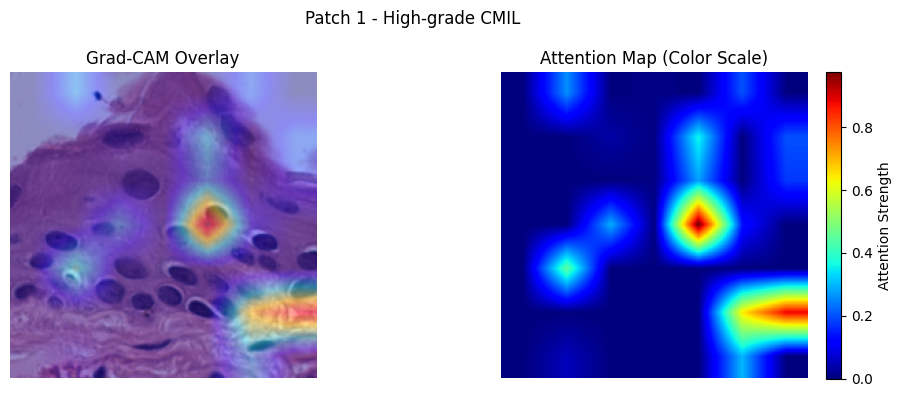

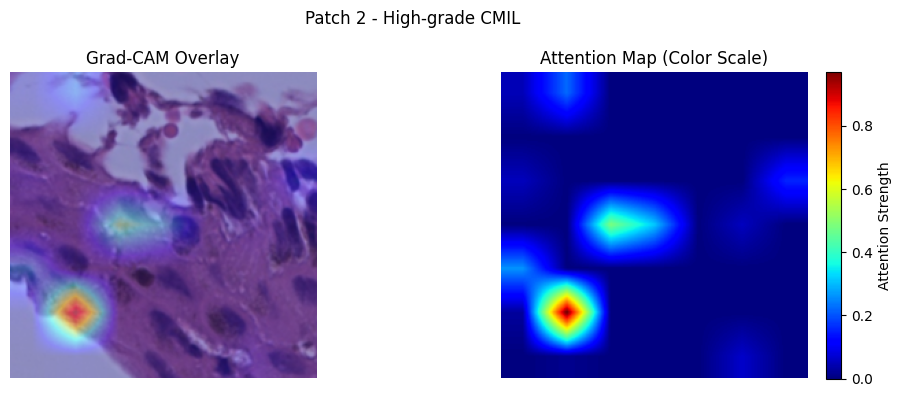

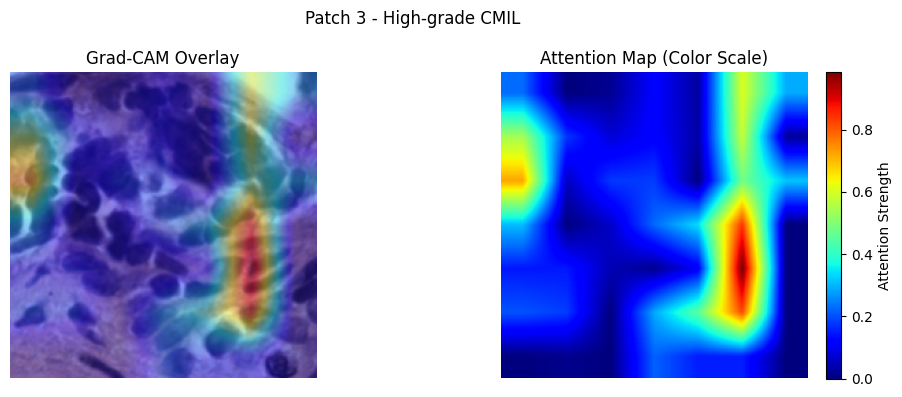

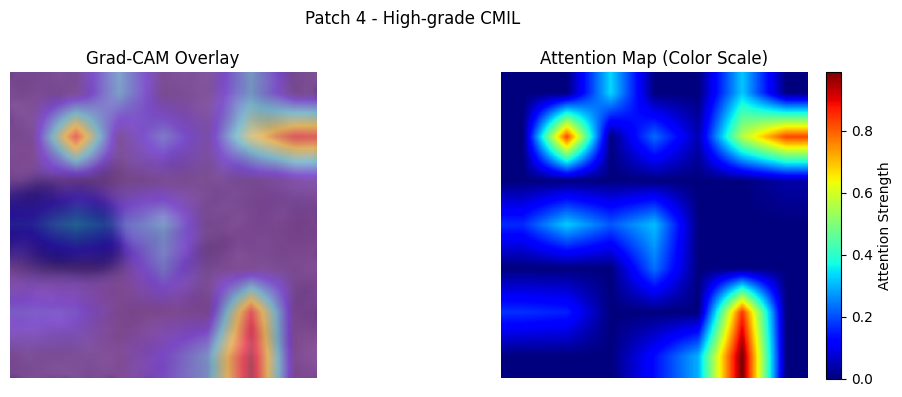

In [ ]:
import cv2
import torch.nn.functional as F


# Set up Grad-CAM once
target_layer = list(model.stages[-1].children())[-1]
grad_cam = GradCAM(model, target_layer=target_layer)
model.to(device)

# Loop over saved patches
for i, item in enumerate(saved_patch_info):
    img_path = item["path"]
    label = item["label"]

    # Load and resize image
    img = Image.open(img_path).convert('RGB').resize((224, 224))
    img_np = np.array(img)

    # Transform for model
    transform_to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform_to_tensor(img).unsqueeze(0).to(device)
    input_tensor.requires_grad_()  # ✅ Required for Grad-CAM

    # Run Grad-CAM
    cam = grad_cam(input_tensor, class_idx=label)

    # Visualize
    class_name = "Benign" if label == 0 else "High-grade CMIL"
    show_gradcam_with_legend(img_np, cam, title=f"Patch {i} - {class_name}")